In [ ]:
!python -m spacy download es_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 53 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import string as st
import re
from nltk.stem import SnowballStemmer
from nltk import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import spacy
import es_core_news_md
import time
sp = es_core_news_md.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_licitaciones_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
0,32500000,32000000,32500000.0,NaN,NaN,Adquisición de repuestos para el ILS AMS 2100,adquisición repuesto
1,65310000,65000000,65300000.0,65310000.0,NaN,Suministro de energía eléctrica en el Centro d...,suministrar energía eléctrico centrar conserva...
2,92112000,92000000,92100000.0,92110000.0,92112000.0,"Servicio de duplicado de copias de películas, ...",servicio duplicar copiar película tráiler vide...
3,9122110,9000000,9100000.0,9120000.0,9122000.0,Gas Licuado Propano 2013/2014,licuar propano
4,75000000,75000000,NaN,NaN,NaN,Servicio de vigilancia del Centro Cultural de ...,servicio vigilancia centrar cultural españa mé...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387194 entries, 0 to 387193
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_cpv        387194 non-null  int64  
 1   id_division   387194 non-null  int64  
 2   id_grupo      344341 non-null  float64
 3   id_clase      282283 non-null  float64
 4   id_categoria  193738 non-null  float64
 5   objeto        387194 non-null  object 
 6   clean_text    387194 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 20.7+ MB


In [ ]:
df.isnull().sum()

id_cpv               0
id_division          0
id_grupo         42853
id_clase        104911
id_categoria    193456
objeto               0
clean_text           0
dtype: int64

In [ ]:
df = df.sample(n=50000, random_state=1)
df

,id_capitulo,id_concepto,id_partida_generica,descripcion
246729,2000,2500,2530,Infliximab SOLUCIÓN INYECTABLE El frasco ámpul...
71686,3000,3200,3250,SERVICIO DE ARRENDAMIENTO INTEGRAL DE VEHÍCULO...
26815,6000,6100,6150,Invitación E350-2018 Seguimiento y control par...
294323,3000,3500,3510,TRABAJOS DE REHABILTACIÓN Y MANTTO. EN LA ESTA...
224244,2000,2500,2530,ADQUISICION DE INSUMOS DE LISOSOMALES (IDURSUL...
...,...,...,...,...
496893,3000,3300,3390,PRESTACIÓN DE SERVICIOS PROFESIONALES DGAQ
299737,3000,3200,3270,Suscripción anual del servicio de correo elect...
73851,3000,3500,3580,CONTRATACIÓN PLURIANUAL DEL SERVICIO INTEGRAL ...
157176,3000,3100,3170,CONTRATACION DE SERVICIO DE CONDUCCION DE SEÑA...


In [ ]:
df.groupby(['id_division']).count()['objeto']

id_division
3000000      3209
9000000      7625
14000000     1009
15000000     4085
16000000      572
18000000     3762
19000000      526
22000000     2710
24000000     2344
30000000     9438
31000000     5062
32000000     3944
33000000    20280
34000000    17050
35000000     5019
37000000     1466
38000000     6610
39000000     6629
41000000      151
42000000     5445
43000000      750
44000000     8228
45000000    65265
48000000     8038
50000000    29686
51000000      897
55000000     9723
60000000     8086
63000000     3208
64000000     3330
65000000      627
66000000     6733
70000000     3343
71000000    20358
72000000    19244
73000000     2101
75000000     1586
76000000       39
77000000     3693
79000000    26186
80000000     6814
85000000    17495
90000000    15482
92000000    14354
98000000     4992
Name: objeto, dtype: int64

### TF-IDF : Term Frequency - Inverse Document Frequency
#### The term frequency is the number of times a term occurs in a document. Inverse document frequency is an inverse function of the number of documents in which a given word occurs.
#### The product of these two terms gives tf-idf weight for a word in the corpus. The higher the frequency of occurrence of a word, lower is it's weight and vice-versa. This gives more weightage to rare terms in the corpus and penalizes more commonly occuring terms.
#### Other widely used vectorizer is Count vectorizer which only considers the frequency of occurrence of a word across the corpus.


In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_division'] # Labels

In [ ]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/1000000.0)))

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
#La proporcion de training and testing
print(X_train.shape)
print(X_test.shape)

(309755,)
(77439,)


In [ ]:
y_train.groupby(y_train).size()

id_division
14      807
15     3268
16      458
18     3010
19      421
22     2168
24     1875
3      2567
30     7550
31     4050
32     3155
33    16224
34    13640
35     4015
37     1173
38     5288
39     5303
41      121
42     4356
43      600
44     6582
45    52212
48     6430
50    23749
51      718
55     7778
60     6469
63     2567
64     2664
65      502
66     5386
70     2674
71    16286
72    15395
73     1681
75     1269
76       31
77     2954
79    20949
80     5451
85    13996
9      6100
90    12386
92    11483
98     3994
Name: id_division, dtype: int64

In [ ]:
y_test.groupby(y_test).size()

id_division
14      202
15      817
16      114
18      752
19      105
22      542
24      469
3       642
30     1888
31     1012
32      789
33     4056
34     3410
35     1004
37      293
38     1322
39     1326
41       30
42     1089
43      150
44     1646
45    13053
48     1608
50     5937
51      179
55     1945
60     1617
63      641
64      666
65      125
66     1347
70      669
71     4072
72     3849
73      420
75      317
76        8
77      739
79     5237
80     1363
85     3499
9      1525
90     3096
92     2871
98      998
Name: id_division, dtype: int64

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf = TfidfVectorizer(ngram_range=(1,3), 
                        analyzer="word", 
                        tokenizer=word_tokenize, 
                        strip_accents='ascii', 
                        max_features=None, 
                        lowercase=True)
tfidf_vect = tfidf.fit(df['clean_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
df[df['clean_text'].str.contains('11')]

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
16921,79320000,79000000,79300000.0,79320000.0,NaN,Realización de los trabajos de campo necesario...,realización trabajo campar necesario redacción...
73647,90919200,90000000,90900000.0,90910000.0,90919000.0,El objeto del contrato es la prestación del se...,objetar contratar prestación servicio limpieza...
129305,79340000,79000000,79300000.0,79340000.0,NaN,patrocinio por parte de la diputación provinci...,patrocinio partir diputación provincial ourens...
189017,92000000,92000000,NaN,NaN,NaN,El objeto del contrato es la realización del s...,objetar contratar realización servicio organiz...
243074,45454100,45000000,45400000.0,45450000.0,45454000.0,Reforma y Rehabilitación en la Undécima Escuad...,reformar rehabilitación 11 escuadrilla
247618,45222300,45000000,45200000.0,45220000.0,45222000.0,Instalación de Sistemas de Seguridad en Estaci...,instalación sistema seguridad estación recepto...
293667,50660000,50000000,50600000.0,50660000.0,NaN,Expediente 2021/AR46U/00001669 Undécimo Contra...,expedientar 11 contratar derivar acordar marca...
297202,50660000,50000000,50600000.0,50660000.0,NaN,20226301 Undécimo contrato derivado del Acuerd...,11 contratar derivar acordar marcar asistencia...
331931,55300000,55000000,55300000.0,NaN,NaN,Undécimo pedido derivado del acuerdo marco 059...,11 pedir derivar acordar marcar servicio cater...
343559,45332200,45000000,45300000.0,45330000.0,45332000.0,Nueva instalación de contra incendios en la Un...,nuevo instalación incendio 11 escuadrilla


In [ ]:
print(len(tfidf.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2307173


In [ ]:
# Get feature names in the vector
tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 '1 acordar',
 '1 acordar marcar',
 '1 adjudicatario',
 '1 adjudicatario abril',
 '1 adjudicatario difcanarsa',
 '1 adjudicatario lote',
 '1 adjudicatario segun',
 '1 aguar',
 '1 aguar intervencion',
 '1 alberto',
 '1 alberto guisar',
 '1 amor',
 '1 amor salar',
 '1 anillar',
 '1 anillar programar',
 '1 anunciar',
 '1 anunciar inalterado',
 '1 auditor',
 '1 auditor proyectar',
 '1 basar',
 '1 basar adquisicion',
 '1 blocar',
 '1 blocar construccion',
 '1 borrador',
 '1 borrador documentar',
 '1 callar',
 '1 callar alfredo',
 '1 canal',
 '1 canal levantar',
 '1 cbam',
 '1 cbam sostenimiento',
 '1 centenario',
 '1 centenario hemeroteca',
 '1 ciclar',
 '1 ciclar almendro',
 '1 ciclar ano',
 '1 ciclar ayuntamiento',
 '1 ciclar babylandia',
 '1 ciclar cadrete',
 '1 ciclar castrillon',
 '1 ciclar centrar',
 '1 ciclar centro',
 '1 ciclar claro',
 '1 ciclar colonia',
 '1 ciclar comandancia',
 '1 ciclar comer',
 '1 ciclar comunitat',
 '1 ciclar cursar',
 '1 ciclar denominar',
 '1 ciclar d

In [ ]:
X_train_Tfidf = tfidf_vect.transform(X_train)
X_test_Tfidf = tfidf_vect.transform(X_test)

In [ ]:
X_train_Tfidf.shape

(309755, 2307173)

In [ ]:
X_test_Tfidf.shape

(77439, 2307173)

In [ ]:
def preprocessing_fastest_v2(text):
  #tokenizamos words 
  token_word = nltk.word_tokenize(text.lower(), "spanish")
  sentence = []
  for token in token_word:
    #omit tokens if are less than 4 characters or are punctuation marks
    if len(token) <= 3 or token in st.punctuation:
      continue
    #omit if the token has numbers
    if not (token.isalpha()):
      continue
    #omit tokens if are stopwords in spanish
    if token in nltk.corpus.stopwords.words('spanish'):
      continue
    sentence.append(token)
  #lematization of sentence
  doc = sp(' '.join(sentence))
  return ' '.join([token.lemma_ for token in doc])

In [ ]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [ ]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##MultinomialNB

In [ ]:
#Model and hyperparameters
parametersMNB = { 
                 'alpha':[0, 0.5, 1.0]
                }
modelMNB = MultinomialNB()

In [ ]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_Tfidf, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.5, 1.0]}, verbose=3)

In [ ]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_Tfidf)

In [ ]:
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'alpha': 0}

Grid scores on testing set:

0.743 (+/-0.000) for {'alpha': 0}
0.649 (+/-0.002) for {'alpha': 0.5}
0.598 (+/-0.001) for {'alpha': 1.0}

best score:  0.7429646016548103

Grid times on testing set:

14.758 seconds (+/-5.461) for {'alpha': 0}
10.961 seconds (+/-0.188) for {'alpha': 0.5}
8.001 seconds (+/-3.333) for {'alpha': 1.0}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.6751493115363307, 'accuracy': 0.766009375121063}
              precision    recall  f1-score   support

          14       0.45      0.57      0.51       202
          15       0.86      0.86      0.86       817
          16       0.52      0.59      0.55       114
          18       0.75      0.73      0.74       752
          19       0.40      0.55      0.47       105
          22       0.73      0.77      0.75       542
       

##LinearSVM

In [ ]:
#For large datasets consider using LinearSVC
parametersSVM = { 
                 'max_iter':[100, 200, 300, 500, 700],
                 'C':[1]
                 }
modelSVM = LinearSVC(C=1.0, 
                     penalty='l2', 
                     class_weight='balanced', 
                     random_state=42, 
                     max_iter=1000, 
                     verbose=3)

In [ ]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_Tfidf, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=2,
             estimator=LinearSVC(class_weight='balanced', max_iter=2000,
                                 random_state=42, verbose=3),
             n_jobs=-1,
             param_grid={'C': [1], 'max_iter': [100, 200, 300, 500, 700]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_Tfidf)

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 1, 'max_iter': 200}

Grid scores on testing set:

0.815 (+/-0.000) for {'C': 1, 'max_iter': 100}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 200}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 300}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 500}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 700}

best score:  0.8146825720519041

Grid times on testing set:

173.398 seconds (+/-12.401) for {'C': 1, 'max_iter': 100}
182.042 seconds (+/-13.761) for {'C': 1, 'max_iter': 200}
237.043 seconds (+/-0.399) for {'C': 1, 'max_iter': 300}
243.627 seconds (+/-6.289) for {'C': 1, 'max_iter': 500}
194.793 seconds (+/-1.771) for {'C': 1, 'max_iter': 700}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7340077033726088, 'accuracy': 0.8408424695566833}
              precision    recall  f1-score   support

          14       0.72      0.71

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 0.5, 'max_iter': 300}

Grid scores on testing set:

0.810 (+/-0.000) for {'C': 0.5, 'max_iter': 300}

best score:  0.809730270998073

Grid times on testing set:

139.848 seconds (+/-5.333) for {'C': 0.5, 'max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7389524871812978, 'accuracy': 0.8351218378336497}
              precision    recall  f1-score   support

          14       0.70      0.71      0.71       202
          15       0.88      0.91      0.90       817
          16       0.67      0.72      0.69       114
          18       0.75      0.80      0.78       752
          19       0.62      0.63      0.63       105
          22       0.79      0.82      0.81       542
          24       0.60      0.76      0.67       469
           3       0.82      0.81      0.81       642
          30  

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 0.9, 'max_iter': 300}

Grid scores on testing set:

0.814 (+/-0.000) for {'C': 0.9, 'max_iter': 300}

best score:  0.8143080824109248

Grid times on testing set:

193.108 seconds (+/-13.201) for {'C': 0.9, 'max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7361341982198111, 'accuracy': 0.8405067214194398}
              precision    recall  f1-score   support

          14       0.72      0.71      0.71       202
          15       0.89      0.92      0.90       817
          16       0.68      0.70      0.69       114
          18       0.77      0.81      0.79       752
          19       0.63      0.61      0.62       105
          22       0.82      0.81      0.81       542
          24       0.60      0.76      0.67       469
           3       0.83      0.80      0.81       642
          30

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 0.1, 'max_iter': 300}

Grid scores on testing set:

0.778 (+/-0.001) for {'C': 0.1, 'max_iter': 300}

best score:  0.7780794516468694

Grid times on testing set:

96.758 seconds (+/-4.637) for {'C': 0.1, 'max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7344779029197782, 'accuracy': 0.8036260798822299}
              precision    recall  f1-score   support

          14       0.62      0.73      0.67       202
          15       0.85      0.89      0.87       817
          16       0.53      0.79      0.64       114
          18       0.71      0.82      0.76       752
          19       0.47      0.69      0.56       105
          22       0.70      0.83      0.76       542
          24       0.70      0.72      0.71       469
           3       0.78      0.81      0.79       642
          30  

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 10, 'max_iter': 300}

Grid scores on testing set:

0.811 (+/-0.001) for {'C': 10, 'max_iter': 300}

best score:  0.8108343699612371

Grid times on testing set:

783.240 seconds (+/-33.286) for {'C': 10, 'max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7162610356063754, 'accuracy': 0.8376141220831881}
              precision    recall  f1-score   support

          14       0.75      0.68      0.71       202
          15       0.89      0.91      0.90       817
          16       0.70      0.67      0.68       114
          18       0.78      0.79      0.78       752
          19       0.68      0.57      0.62       105
          22       0.85      0.80      0.82       542
          24       0.60      0.74      0.66       469
           3       0.83      0.79      0.81       642
          30   

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 1, 'max_iter': 300}

Grid scores on testing set:

0.693 (+/-0.002) for {'C': 0.01, 'max_iter': 300}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 300}
0.805 (+/-0.001) for {'C': 100, 'max_iter': 300}

best score:  0.8146825720519041

Grid times on testing set:

101.103 seconds (+/-7.313) for {'C': 0.01, 'max_iter': 300}
209.528 seconds (+/-9.333) for {'C': 1, 'max_iter': 300}
1495.097 seconds (+/-26.242) for {'C': 100, 'max_iter': 300}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7345368039017094, 'accuracy': 0.8408424695566833}
              precision    recall  f1-score   support

          14       0.72      0.71      0.71       202
          15       0.89      0.92      0.90       817
          16       0.68      0.68      0.68       114
          18       0.77      0.81      0.79       752
          19   

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 1, 'max_iter': 500}

Grid scores on testing set:

0.693 (+/-0.002) for {'C': 0.01, 'max_iter': 500}
0.815 (+/-0.000) for {'C': 1, 'max_iter': 500}

best score:  0.8146825720519041

Grid times on testing set:

97.031 seconds (+/-5.337) for {'C': 0.01, 'max_iter': 500}
208.362 seconds (+/-15.591) for {'C': 1, 'max_iter': 500}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7345368039017094, 'accuracy': 0.8408424695566833}
              precision    recall  f1-score   support

          14       0.72      0.71      0.71       202
          15       0.89      0.92      0.90       817
          16       0.68      0.68      0.68       114
          18       0.77      0.81      0.79       752
          19       0.64      0.60      0.62       105
          22       0.82      0.81      0.81       542
          24     

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 1, 'class_weight': None, 'max_iter': 1000}

Grid scores on testing set:

0.815 (+/-0.000) for {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
0.815 (+/-0.001) for {'C': 1, 'class_weight': None, 'max_iter': 1000}

best score:  0.814814933297777

Grid times on testing set:

216.044 seconds (+/-13.463) for {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
126.072 seconds (+/-5.363) for {'C': 1, 'class_weight': None, 'max_iter': 1000}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7032907264356092, 'accuracy': 0.8424695566833249}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          14       0.84      0.66      0.74       202
          15       0.90      0.91      0.90       817
          16       0.74      0.65      0.69       114
          18       0.81      0.76      0.78       752
          19       0.70      0.50      0.58       105
          22       0.87      0.77      0.82       542
          24       0.85      0.68      0.76       469
           3       0.84      0.79      0.82       642
          30       0.80      0.82      0.81      1888
          31       0.72      0.54      0.62      1012
          32       0.66      0.59      0.62       789
          33       0.87      0.93      0.90      4056
          34       0.81      0.83      0.82      3410
          35       0.73      0.62      0.67      1004
          37       0.86      0.63      0.73       293
          38       0.73      0.77      0.75      1322
          39       0.80      0.71      0.75      1326
          41       0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##SGDClassifier

In [ ]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [ ]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_Tfidf, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 1.84, NNZs: 21521, Bias: -0.017904, T: 278779, Avg. loss: 0.000263
Total training time: 0.29 seconds.
Norm: 4.28, NNZs: 24635, Bias: -0.040310, T: 278779, Avg. loss: 0.000767
Total training time: 0.34 seconds.
-- Epoch 2
-- Epoch 2
Norm: 1.02, NNZs: 24225, Bias: -0.012783, T: 557558, Avg. loss: 0.000014
Total training time: 0.69 seconds.
Norm: 2.40, NNZs: 28058, Bias: -0.030609, T: 557558, Avg. loss: 0.000061
Total training time: 0.73 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.71, NNZs: 25132, Bias: -0.010014, T: 836337, Avg. loss: 0.000005
Total training time: 1.09 seconds.
Norm: 1.67, NNZs: 28885, Bias: -0.027448, T: 836337, Avg. loss: 0.000028
Total training time: 1.14 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.55, NNZs: 25684, Bias: -0.007907, T: 1115116, Avg. loss: 0.000003
Total training time: 1.47 seconds.
Norm: 1.29, NNZs: 29286, Bias: -0.025256, T: 1115116, Avg. loss: 0.000015
Total training time: 1.53 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.45, NNZs: 26106,

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.9s


-- Epoch 1
Norm: 0.62, NNZs: 45794, Bias: -0.006088, T: 1393895, Avg. loss: 0.000003
Total training time: 1.87 seconds.
Norm: 1.80, NNZs: 145179, Bias: -0.006177, T: 278779, Avg. loss: 0.000604
Total training time: 0.30 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.52, NNZs: 46389, Bias: -0.005253, T: 1672674, Avg. loss: 0.000002
Total training time: 2.23 seconds.
Convergence after 6 epochs took 2.33 seconds
Norm: 1.06, NNZs: 169165, Bias: -0.003499, T: 557558, Avg. loss: 0.000043
Total training time: 0.72 seconds.
-- Epoch 1
-- Epoch 3
Norm: 1.86, NNZs: 42473, Bias: -0.011389, T: 278779, Avg. loss: 0.000245
Total training time: 0.26 seconds.
-- Epoch 2
Norm: 0.76, NNZs: 179322, Bias: -0.002185, T: 836337, Avg. loss: 0.000015
Total training time: 1.15 seconds.
-- Epoch 4
Norm: 1.03, NNZs: 49478, Bias: -0.008328, T: 557558, Avg. loss: 0.000010
Total training time: 0.60 seconds.
-- Epoch 3
Norm: 0.60, NNZs: 184978, Bias: -0.002329, T: 1115116, Avg. loss: 0.000008
Total training time: 1.52 secon

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   58.8s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [200, 300, 500]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_Tfidf)

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'perceptron', 'max_iter': 200}

Grid scores on testing set:

0.764 (+/-0.000) for {'loss': 'modified_huber', 'max_iter': 200}
0.764 (+/-0.000) for {'loss': 'modified_huber', 'max_iter': 300}
0.764 (+/-0.000) for {'loss': 'modified_huber', 'max_iter': 500}
0.762 (+/-0.003) for {'loss': 'squared_hinge', 'max_iter': 200}
0.762 (+/-0.003) for {'loss': 'squared_hinge', 'max_iter': 300}
0.762 (+/-0.003) for {'loss': 'squared_hinge', 'max_iter': 500}
0.767 (+/-0.001) for {'loss': 'perceptron', 'max_iter': 200}
0.767 (+/-0.001) for {'loss': 'perceptron', 'max_iter': 300}
0.767 (+/-0.001) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.7673354767155925

Grid times on testing set:

57.495 seconds (+/-0.009) for {'loss': 'modified_huber', 'max_iter': 200}
58.489 seconds (+/-0.375) for {'loss': 'modified_huber', 'max_iter': 300}
56.632 seconds (+/-0.014) for {'loss': 'modified_huber', 'max_iter': 500}
56.106 seconds

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

In [ ]:
print(multi_label_metrics(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

{'balanced_accuracy_score': 0.6705608272071176, 'accuracy': 0.8141246658660365}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          14       0.89      0.60      0.72       202
          15       0.89      0.88      0.89       817
          16       0.63      0.52      0.57       114
          18       0.79      0.76      0.77       752
          19       0.72      0.48      0.57       105
          22       0.77      0.77      0.77       542
          24       0.73      0.69      0.71       469
           3       0.81      0.78      0.80       642
          30       0.75      0.77      0.76      1888
          31       0.61      0.49      0.54      1012
          32       0.66      0.49      0.56       789
          33       0.84      0.91      0.87      4056
          34       0.81      0.78      0.79      3410
          35       0.61      0.63      0.62      1004
          37       0.86      0.57      0.68       293
          38       0.72      0.71      0.71      1322
          39       0.75      0.67      0.71      1326
          41       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing_fastest_v2(example) for example in examples]
examples

In [ ]:
examples_Tfidf = tfidf_vect.transform(examples)

In [ ]:
#Prediction
test = clf_GS_SGD.predict(examples_Tfidf)
test

##RandomForest

In [ ]:
modelRF = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1, verbose=3)

In [ ]:
# Entrenamiento del algoritmo 
modelRF.fit(X_train_Tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 18.7min


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 32.9min finished


RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42, verbose=3)

In [ ]:
# Let's see the results
y_pred = modelRF.predict(X_test_Tfidf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    4.2s finished


In [ ]:
print(multi_label_metrics(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

{'balanced_accuracy_score': 0.6584189177131522, 'accuracy': 0.8074226165110603}
              precision    recall  f1-score   support

          14       0.79      0.60      0.69       202
          15       0.87      0.87      0.87       817
          16       0.70      0.61      0.65       114
          18       0.73      0.74      0.74       752
          19       0.59      0.43      0.50       105
          22       0.86      0.75      0.80       542
          24       0.56      0.70      0.62       469
           3       0.81      0.77      0.79       642
          30       0.80      0.71      0.75      1888
          31       0.69      0.45      0.54      1012
          32       0.64      0.48      0.55       789
          33       0.78      0.89      0.83      4056
          34       0.72      0.81      0.76      3410
          35       0.71      0.55      0.62      1004
          37       0.82      0.61      0.70       293
          38       0.65      0.70      0.68      1322
 

<Figure size 432x288 with 0 Axes>

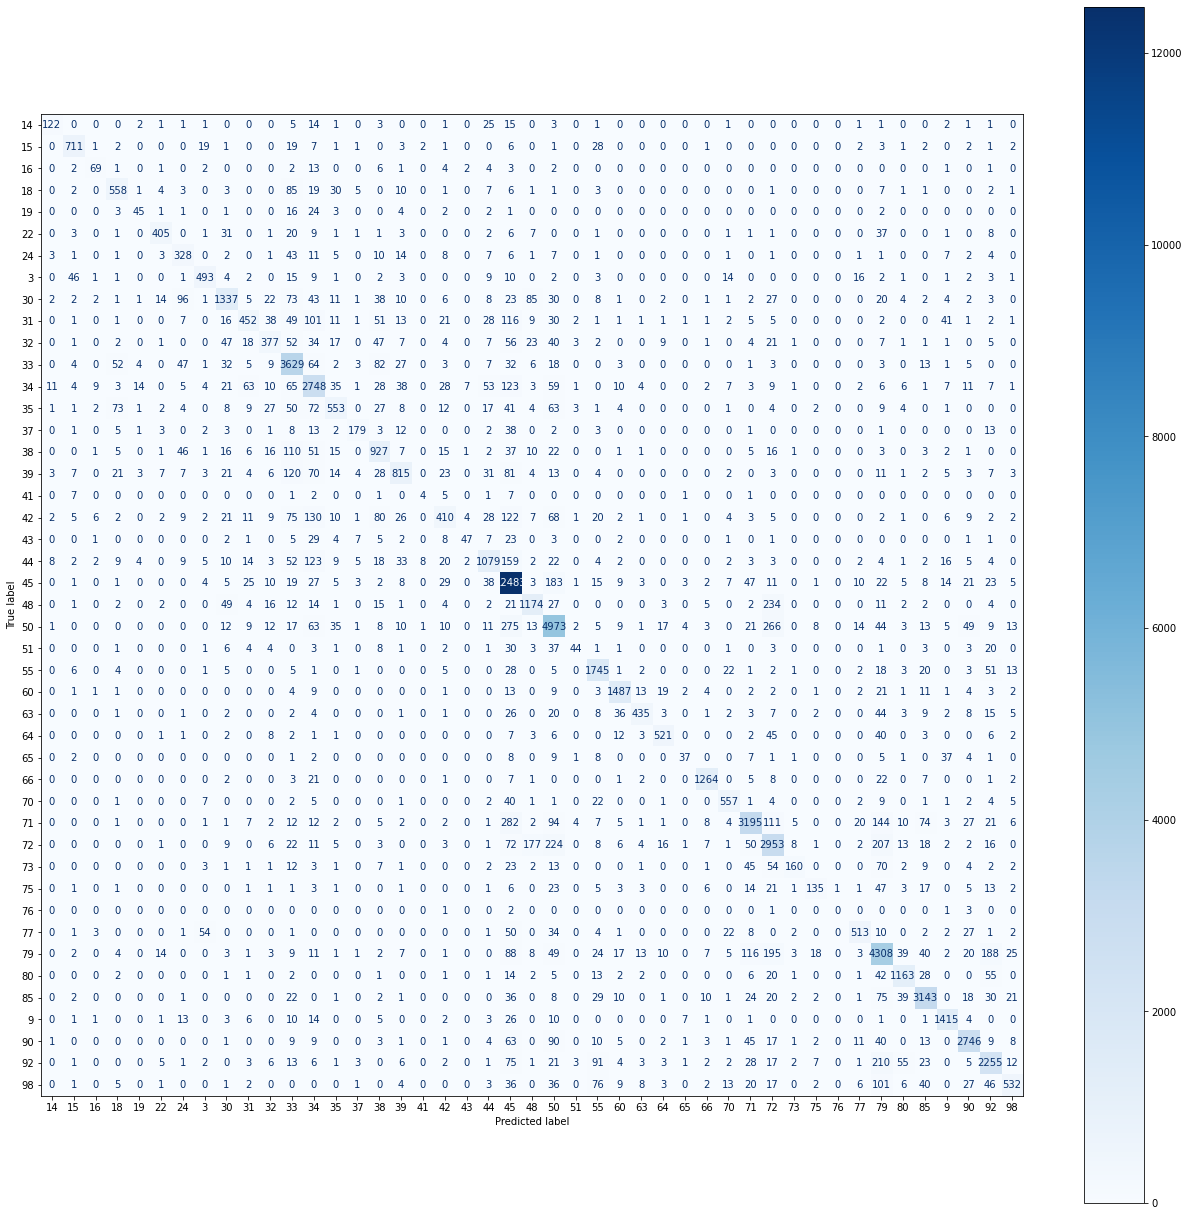

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(22,22))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

Pipeline solo el TF-IDF y GridSearchCV



In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_division'] # Labels

In [ ]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/1000000.0)))

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
#La proporcion de training and testing
print(X_train.shape)
print(X_test.shape)

(309755,)
(77439,)


In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf_pl = TfidfVectorizer(analyzer="word", tokenizer=word_tokenize, strip_accents='ascii', max_features=None, lowercase=True)

In [ ]:
#For large datasets consider using LinearSVC
model_SVM = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=True)

In [ ]:
#Parameters to test
parameters_grid = {
              'svm__C': (1, 5, 10),
              'svm__penalty':('l1', 'l2'),
              'svm__class_weight':('balanced', None),
              'svm__max_iter':[500, 800, 1000, 1500],
              }
#scoring method
scoring = ['accuracy', 'precision']

In [ ]:
#Model
clf_svm = Pipeline([
    ('vectorizer', tfidf_pl),
    ('svm', model_SVM)
])
gsSVM=RandomizedSearchCV(clf_svm, parameters_grid, cv=5, n_jobs=-1, verbose=3)
gsSVM.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages

[LibLinear]

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(strip_accents='ascii',
                                                              tokenizer=<function word_tokenize at 0x7fba386cfd40>)),
                                             ('svm',
                                              LinearSVC(class_weight='balanced',
                                                        random_state=42,
                                                        verbose=True))]),
                   n_jobs=-1,
                   param_distributions={'svm__C': (1, 5, 10),
                                        'svm__class_weight': ('balanced', None),
                                        'svm__max_iter': [500, 800, 1000, 1500],
                                        'svm__penalty': ('l1', 'l2')},
                   verbose=3)

In [ ]:
print("best parameters: ",gsSVM.best_params_)
print("best score: ", gsSVM.best_score_)

In [ ]:
best_estim=gsSVM.best_estimator_

In [ ]:
best_estim.fit(X_train, y_train)

In [ ]:
# Let's see the results
y_pred = best_estim.predict(X_test)

In [ ]:
# Let's see the results
y_pred = clf_svm.predict(X_test)
y_pred

array(['64', '85', '50', ..., '64', '85', '39'], dtype=object)

In [ ]:
print(multi_label_metrics(y_test, y_pred))

{'balanced_accuracy_score': 0.7039804730959143, 'accuracy': 0.7818541045209778}


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          14       0.57      0.73      0.64       202
          15       0.83      0.88      0.86       817
          16       0.50      0.78      0.61       114
          18       0.67      0.80      0.73       752
          19       0.40      0.69      0.50       105
          22       0.66      0.79      0.72       542
          24       0.62      0.70      0.66       469
           3       0.76      0.78      0.77       642
          30       0.75      0.76      0.75      1888
          31       0.50      0.52      0.51      1012
          32       0.45      0.63      0.52       789
          33       0.90      0.86      0.88      4056
          34       0.81      0.72      0.76      3410
          35       0.54      0.58      0.56      1004
          37       0.56      0.71      0.63       293
          38       0.66      0.75      0.70      1322
          39       0.70      0.69      0.69      1326
          41       0.18    

Pipeline Preprocess, TF-IDF y Model

In [ ]:
#Este metodo es para pipelenizar una funcion 
transformer = FunctionTransformer(preprocessing_fastest_v2)
start = time.time()
print(transformer.transform('SERVICIOS PROFESIONALES CONSISTENTES EN LA COORDINACIÓN DEL PROGRAMA CULTURAL DEL PROYECTO BOSQUE DE CHAPULTEPEC NATURALEZA Y CULTURA, A TRAVÉS DE SUS EJES: LA CONEXIÓN ENTRE LO BIOLÓGICO Y LO CULTURAL'))
end = time.time()
print(end - start)

servicio profesional consistente coordinación programar cultural proyectar bosque chapultepec naturaleza cultura través eje conexión biológico cultural
0.02160477638244629


In [ ]:
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['descripcion'] # Text
Y = df['id_capitulo'] # Labels

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf_all = TfidfVectorizer(analyzer="word", tokenizer=word_tokenize, strip_accents='ascii', max_features=None, lowercase=True)

In [ ]:
#For large datasets consider using LinearSVC
model_all = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
#Model
clf_all = Pipeline([
    ('preprocess', pipelinize(preprocessing_fastest_v2)),
    ('vectorizer', tfidf_all),
    ('svm', model_all)
])
clf_all.fit(X_train, y_train)

[LibLinear]

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fd2f1fe9f80>,
                                     kw_args={'active': True})),
                ('vectorizer',
                 TfidfVectorizer(strip_accents='ascii',
                                 tokenizer=<function word_tokenize at 0x7fd305323e60>)),
                ('svm',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [ ]:
# Let's see the results
y_pred = clf_all.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.94      0.94      0.94      4307
        3000       0.95      0.92      0.93      4298
        5000       0.54      0.65      0.59       284
        6000       0.91      0.94      0.92      1111

    accuracy                           0.92     10000
   macro avg       0.83      0.86      0.85     10000
weighted avg       0.93      0.92      0.93     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

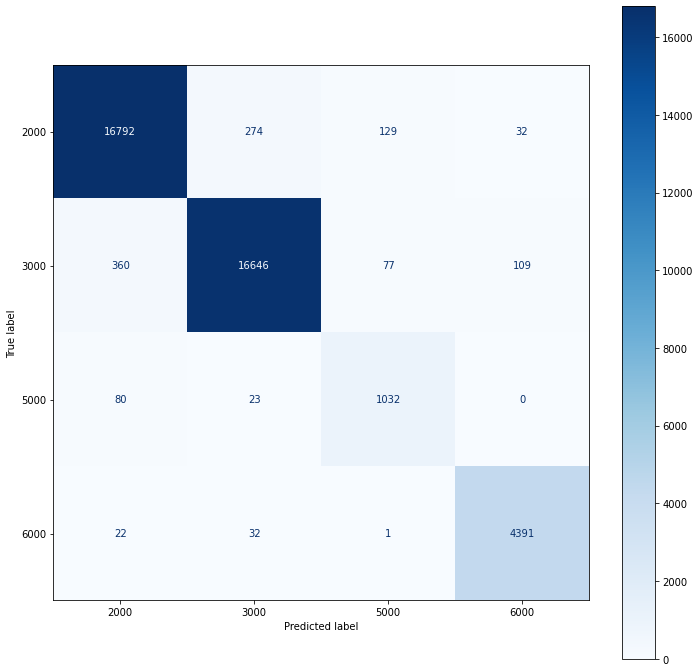

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_all, X_train, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

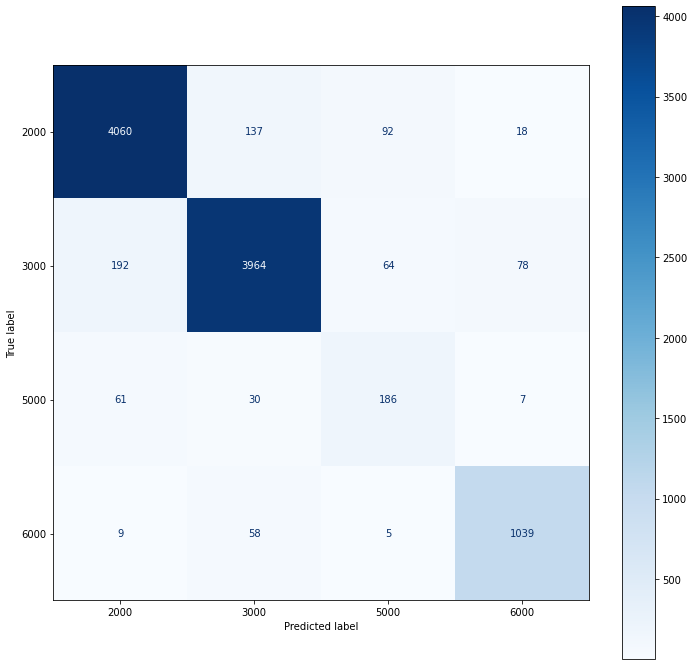

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_all, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

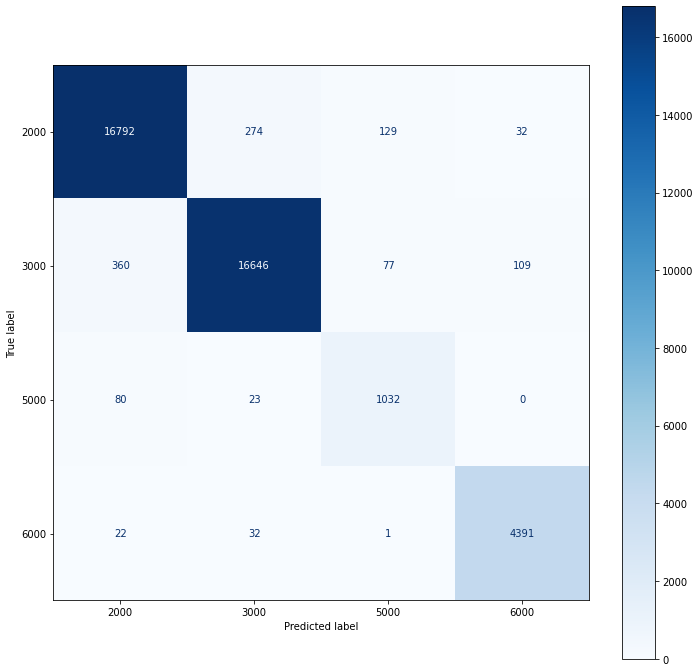

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(clf_all, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

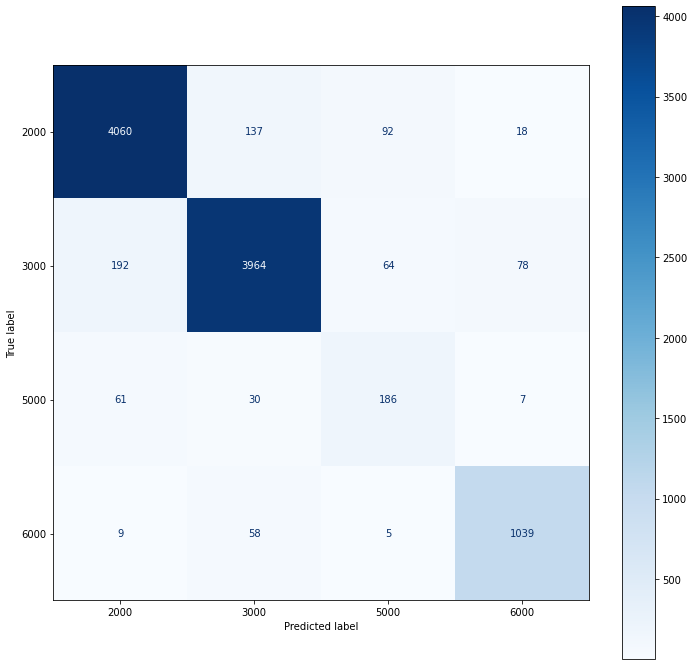

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples again: No es necesario hacer ningún preprocess
test = clf_all.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

array([2000, 3000, 6000, 2000, 5000, 6000])